# cadCAD Tutorials: The Robot and the Marbles, part 4
In parts [1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) and [2](../robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

In [part 3](../robot-marbles-part-3/robot-marbles-part-3.ipynb) we covered how to describe the presence of asynchronous subsystems within the system being modeled in cadCAD.

So far, all the examples referred to deterministic systems: no matter how many times you ran one of those simulations, the results would be the same. However, systems are more commonly non-deterministic, and modelling them as deterministic might be an oversimplification sometimes. 

In this notebook, we'll cover cadCAD's support for modelling non-deterministic systems and Monte Carlo simulations. But first let's copy the base configuration with which we ended Part 3. Here's the description of that system:

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and __two__ robot arms capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robots are programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. They repeat that process until the boxes contain an equal number of marbles.
* The robots act __asynchronously__; robot 1 acts once every two timesteps, and robot 2 acts once every three timesteps.

Note: [Google Colab](https://colab.research.google.com/notebook#create=true&language=python3) is a very useful tool for running cadCAD models. You can access this tutorial in Google Colab [here](https://colab.research.google.com/github/BlockScience/cadCAD/blob/master/tutorials/robot-marbles-part-4/robot-marbles-part-4.ipynb).

In [1]:
%%capture
!pip install cadCAD

In [2]:
%%capture
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
initial_conditions = {
    'box_A': 10, # as per the description of the example, box_A starts out with 10 marbles in it
    'box_B': 0 # as per the description of the example, box_B starts out empty
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(10),
    'N': 1,
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the robot arm's logic in a Policy Function
def robot_arm(params, step, sL, s):
    add_to_A = 0
    if (s['box_A'] > s['box_B']):
        add_to_A = -1
    elif (s['box_A'] < s['box_B']):
        add_to_A = 1
    return({'add_to_A': add_to_A, 'add_to_B': -add_to_A})
    
robots_periods = [2,3] # Robot 1 acts once every 2 timesteps; Robot 2 acts once every 3 timesteps

def robot_arm_1(params, step, sL, s):
    _robotId = 1
    if s['timestep']%robots_periods[_robotId-1]==0: # on timesteps that are multiple of 2, Robot 1 acts
        return robot_arm(params, step, sL, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 1 doesn't interfere with the system

def robot_arm_2(params, step, sL, s):
    _robotId = 2
    if s['timestep']%robots_periods[_robotId-1]==0: # on timesteps that are multiple of 3, Robot 2 acts
        return robot_arm(params, step, sL, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 2 doesn't interfere with the system

    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)
def increment_A(params, step, sL, s, _input):
    y = 'box_A'
    x = s['box_A'] + _input['add_to_A']
    return (y, x)

def increment_B(params, step, sL, s, _input):
    y = 'box_B'
    x = s['box_B'] + _input['add_to_B']
    return (y, x)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': increment_A,
            'box_B': increment_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)

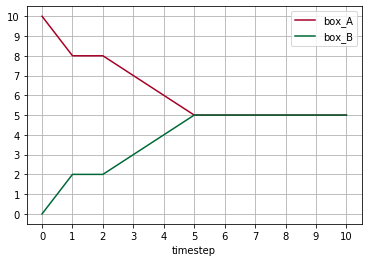

In [3]:
df.plot('timestep', ['box_A', 'box_B'], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        colormap = 'RdYlGn',
        yticks=list(range(1+(df['box_A']+df['box_B']).max())));

# Non-determinism
Non-deterministic systems exhibit different behaviors on different runs for the same input. The order of heads and tails in a series of 3 coin tosses, for example, is non deterministic. 

Our robots and marbles system is currently modelled as a deterministic system. Meaning that every time we run the simulation: none of the robots act on timestep 1; robot 1 acts on timestep 2; robot 2 acts on timestep 3; an so on. 

If however we were to define that at every timestep each robot would act with a probability P, then we would have a non-deterministic (probabilistic) system. Let's make the following changes to our system.
* Robot 1: instead of acting once every two timesteps, there's a 50% chance it will act in any given timestep
* Robot 2: instead of acting once every three timesteps, there's a 33.33% chance it will act in any given timestep

In [4]:
%%capture
from numpy.random import rand

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify each of the robots logic in a Policy Function
robots_probabilities = [0.5,1/3] # Robot 1 acts with a 50% probability; Robot 2, 33.33%

def robot_arm_1(params, step, sL, s):
    _robotId = 1
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sL, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system

def robot_arm_2(params, step, sL, s):
    _robotId = 2
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sL, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': increment_A,
            'box_B': increment_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

If we run the simulation with those configurations, the system is unlikely to exhibit the same behavior as it did in its deterministic version

In [5]:
%%capture
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

df = pd.DataFrame(raw_result)

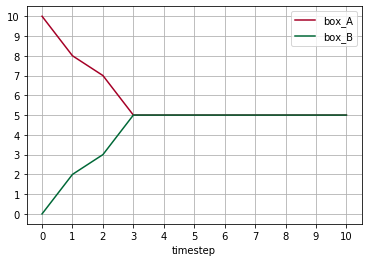

In [6]:
df.plot('timestep', ['box_A', 'box_B'], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        colormap = 'RdYlGn',
        yticks=list(range(1+(df['box_A']+df['box_B']).max())));

And if we run it again, it returns yet another result

In [7]:
%%capture
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

df = pd.DataFrame(raw_result)

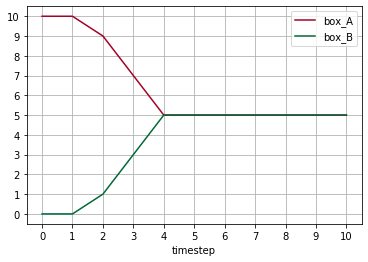

In [8]:
df.plot('timestep', ['box_A', 'box_B'], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        colormap = 'RdYlGn',
        yticks=list(range(1+(df['box_A']+df['box_B']).max())));

In order to take advantage of cadCAD's Monte Carlo simulation features, we should modify the configuration file so as to define the number of times we want the same simulation to be run. This is done in the `N` key of the `simulation_parameters` dict.

In [9]:
%%capture
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(10),
    'N': 50, # We'll run the same simulation 50 times; the random events in each simulation are independent
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

df = pd.DataFrame(raw_result)

In [10]:
from IPython.display import display
tmp_rows = pd.options.display.max_rows
pd.options.display.max_rows = 10
display(df.set_index(['run', 'timestep', 'substep']))
pd.options.display.max_rows = tmp_rows

box_A  box_B
run timestep substep              
1   0        0           10      0
    1        1            9      1
    2        1            9      1
    3        1            8      2
    4        1            6      4
...                     ...    ...
50  6        1            8      2
    7        1            8      2
    8        1            8      2
    9        1            8      2
    10       1            7      3

[550 rows x 2 columns]

Plotting two of those runs allows us to see the different behaviors over time.

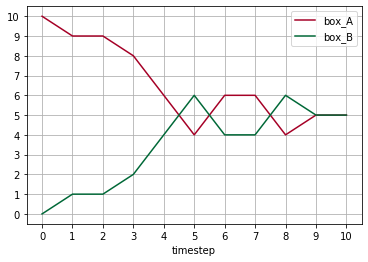

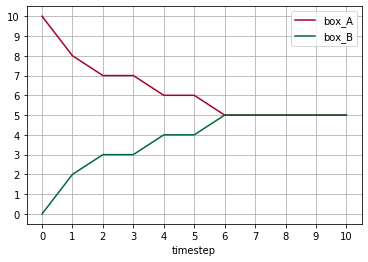

In [11]:
df[df['run']==1].plot('timestep', ['box_A', 'box_B'], grid=True,
                          xticks=list(df['timestep'].drop_duplicates()), 
                          yticks=list(range(11)),
                          colormap = 'RdYlGn');
df[df['run']==9].plot('timestep', ['box_A', 'box_B'], grid=True,
                            xticks=list(df['timestep'].drop_duplicates()), 
                            yticks=list(range(11)),
                            colormap = 'RdYlGn');

If we plot all those runs onto a single chart, we can see every possible trajectory for the number of marbles in each box.

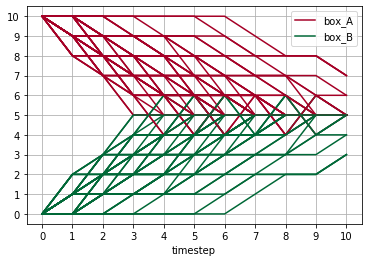

In [12]:
ax = None
for i in range(simulation_parameters['N']):
    ax = df[df['run']==i+1].plot('timestep', ['box_A', 'box_B'],
                                     grid=True,
                                     xticks=list(df['timestep'].drop_duplicates()), 
                                     yticks=list(range(1+max(df['box_A'].max(),df['box_B'].max()))),
                                     legend = (ax == None),
                                     colormap = 'RdYlGn',
                                     ax = ax
                                  )

For some analyses, it might make sense to look at the data in aggregate. Take the median for example:

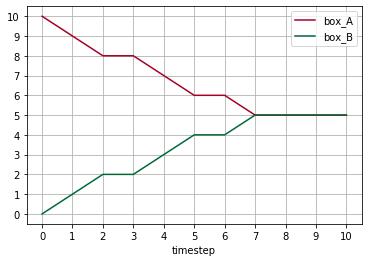

In [13]:
dfmc_median = df.groupby(['timestep', 'substep']).median().reset_index()
dfmc_median.plot('timestep', ['box_A', 'box_B'], 
                 grid=True,
                 xticks=list(dfmc_median['timestep'].drop_duplicates()), 
                 yticks=list(range(int(1+max(dfmc_median['box_A'].max(),dfmc_median['box_B'].max())))),
                 colormap = 'RdYlGn'
                )

Or look at edge cases

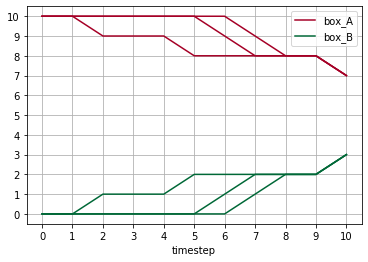

In [14]:
max_final_A = df[df['timestep']==df['timestep'].max()]['box_A'].max()
# max_final_A
slow_runs = df[(df['timestep']==df['timestep'].max()) & 
         (df['box_A']==max_final_A)]['run']
slow_runs = list(slow_runs)
slow_runs

ax = None
for i in slow_runs:
    ax = df[df['run']==i].plot('timestep', ['box_A', 'box_B'],
                                     grid=True,
                                     xticks=list(df['timestep'].drop_duplicates()), 
                                     yticks=list(range(1+max(df['box_A'].max(),df['box_B'].max()))),
                                     legend = (ax == None),
                                     colormap = 'RdYlGn',
                                     ax = ax
                                  )

We invite the reader to fork this code and come up with answers for their other questions that might be interesting to look at. For example:
* How often does box B momentarily contain more marbles than box A?
* What's the frequency distribution of the time to reach equilibrium?
* What's the probability distribution of the waiting times of each one of the robots?